In [1]:
!pip install --upgrade pip
!pip install tensorflow

     |████████████████████████████████| 1.5 MB 4.2 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
     |███████████████████▎            | 310.1 MB 21.5 MB/s eta 0:00:103     |████████████▌                   | 200.8 MB 103.6 MB/s eta 0:00:04

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 516.2 MB 12 kB/s /s eta 0:00:01
     |████████████████████████████████| 57 kB 1.8 MB/s  eta 0:00:01
     |████████████████████████████████| 63 kB 5.1 MB/s  eta 0:00:01
     |████████████████████████████████| 3.0 MB 70.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 84.8 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 71.7 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 102.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 421 kB/s  eta 0:00:01
     |████████████████████████████████| 90 kB 21.5 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 19.3 MB/s eta 0:00:01
     |████████████████████████████████| 777 kB 105.5 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 100.2 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 102.4 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4830 sha256=e3fc2090afc

In [19]:
!pip install pyflux

     |████████████████████████████████| 1.3 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 953 kB 13.6 MB/s eta 0:00:01
  Created wheel for pyflux: filename=pyflux-0.4.15-cp36-cp36m-linux_x86_64.whl size=5130318 sha256=4655ae817e2b24b62fd14d8052062178ae784383d8229b6cfc1263e73f9714c5
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d0/75/75/5e6c26d910209766f8aa4bd6940e391277eb3ec2a3501f9965
Successfully built pyflux


In [92]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib import dates

from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.tsa.vector_ar.var_model import VAR

import pyflux as pf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import tensorflow as tf
keras = tf.keras

from datetime import datetime


---
# User-defined Functions

In [3]:
def calc_rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

def lstm_uni_train_test_split(lmp_curve, n_prev, date_delim_idx):
    lmp_train = lmp_curve[:date_delim_idx]
    lmp_test = lmp_curve[date_delim_idx:]
    X_train, y_train = windowize_data(lmp_train, n_prev)
    X_test, y_test = windowize_data(lmp_test, n_prev)
    return X_train, X_test, y_train, y_test

---
# Data Import and Processing

In [105]:
def import_process_data():
    caiso = pd.read_csv('data/caiso_master.csv')
    caiso.drop('Unnamed: 0', axis=1, inplace=True)
    caiso['INTERVAL_START_PT'] = pd.to_datetime(caiso['INTERVAL_START_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso['INTERVAL_END_PT'] = pd.to_datetime(caiso['INTERVAL_END_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso['date_hour_start'] = pd.to_datetime(caiso['date_hour_start']).apply(lambda x: x.replace(tzinfo=None))
    caiso['OPR_DT_PT'] = pd.to_datetime(caiso['OPR_DT_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso.set_index('INTERVAL_START_PT', inplace=True)
    caiso.rename({'HH_$_million_BTU_not_seasonal_adj': 'HH_$_mill_BTU', 'total_mw':'total_gen'},axis=1, inplace=True)
    caiso['HH_$_mill_BTU'] = pd.to_numeric(caiso['HH_$_mill_BTU'])
    return caiso

In [106]:
caiso = import_process_data()

In [51]:
caiso.reset_index(inplace=True)

In [53]:
type(caiso['INTERVAL_START_PT'])

pandas.core.series.Series

In [5]:
np_lmp_arr = caiso['$_MWH_np15'].values
sp_lmp_arr = caiso['$_MWH_sp15'].values
zp_lmp_arr = caiso['$_MWH_zp26'].values
datetime_arr = caiso['I'].to_period('H')

In [10]:
one_week_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-05-24'])
two_week_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-05-17'])
one_month_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-05-01'])
two_month_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-04-01'])
one_week_idx

11351

---
# ARIMA Univariate Functions

In [6]:
def uni_var_train_test_split(lmp_curve, date_rng, date_delim_idx):
    lmp_train_curve = lmp_curve[:date_delim_idx]
    lmp_test_curve = lmp_curve[date_delim_idx:]
    date_train_rng = date_rng[:date_delim_idx]
    date_test_rng = date_rng[date_delim_idx:]
    return lmp_train_curve, lmp_test_curve, date_train_rng, date_test_rng

def arima_uni_var_fit(lmp_train, date_rng, p, d, q):
    return ARIMA(endog=lmp_train, dates=date_rng, order=(p, d, q)).fit()

def arima_uni_var_predict(model, n_period_fcst):
    return model.forecast(steps=n_period_fcst)[0]

def plot_lstm_v_arima_vs_actuals(y_true, y_lstm, y_arima, date_rng):
    fig, ax = plt.subplots(figsize=(20,6))
    ax.plot(date_rng, y_lstm, 'g.-', label='LSTM', lw=2)
    ax.plot(date_rng, y_arima, 'b.-', label='ARIMA', lw=2)
    ax.plot(date_rng, y_true, 'r.', label='Actual')
    ax.set_title('Prediction vs Actual', fontsize=18, fontweight='bold')
    ax.set_xlabel('$/MWh', fontsize=12)
    ax.legend();

---
# NP-15

In [26]:
train_test_date_delim_idx = 11270

np_multi_var_df = caiso[['$_MWH_np15', 'load_MW', 'HH_$_mill_BTU', 'other', 'solar', 'wind']].copy()
np_multi_var_train = np_multi_var_df.iloc[: train_test_date_delim_idx, :]
np_multi_var_test = np_multi_var_df.iloc[train_test_date_delim_idx :, :]

#### ARIMA Univariate Forecast

In [7]:
np_uni_train, np_uni_test, np_train_rng, np_test_rng = uni_var_train_test_split(np_lmp_arr, datetime_arr, train_test_date_delim_idx)
np_uni_arima = arima_uni_var_fit(np_uni_train, np_train_rng, 24, 1, 0)
np_uni_arima_pred = arima_uni_var_predict(np_uni_arima, 24 * 7)

In [8]:
np_uni_arima_pred = arima_uni_var_predict(np_uni_arima, 249)

In [9]:
rmse_np_uni_arima = round(calc_rmse(np_uni_arima_pred, np_uni_test), 6)
print(f"RMSE: {rmse_np_uni_arima}")

RMSE: 4.388116


#### LSTM Univariate

In [11]:
# 1 week
batch_size = 24 * 7
train_test_allocation = batch_size / len(caiso)

X1_train, X1_test, y1_train, y1_test = split_and_windowize(np_lmp_arr, int(batch_size / 2), train_test_allocation)
n_features = X1_train.shape[2]

np_lstm_uni = keras.Sequential()
np_lstm_uni.add(keras.layers.LSTM(32, input_shape=(batch_size, n_features), return_sequences=True))
np_lstm_uni.add(keras.layers.LSTM(32, return_sequences=True))
np_lstm_uni.add(keras.layers.LSTM(32, return_sequences=False))
# The Dense value is the output sequence.
np_lstm_uni.add(keras.layers.Dense(1, activation='linear'))
np_lstm_uni.compile(optimizer='adam',loss='mse')

In [12]:
windowize_data

<function __main__.windowize_data(data, n_prev)>

In [13]:
np_lstm_uni.fit(X1_train, y1_train, batch_size, epochs=20)


Epoch 1/20
67/67 [==============================] - 8s 119ms/step - loss: 1290.8796
Epoch 2/20
67/67 [==============================] - 8s 114ms/step - loss: 1025.8043
Epoch 3/20
67/67 [==============================] - 8s 114ms/step - loss: 915.2725
Epoch 4/20
67/67 [==============================] - 8s 115ms/step - loss: 829.1397
Epoch 5/20
67/67 [==============================] - 8s 114ms/step - loss: 758.5579
Epoch 6/20
67/67 [==============================] - 8s 114ms/step - loss: 697.0353
Epoch 7/20
67/67 [==============================] - 8s 114ms/step - loss: 639.9954
Epoch 8/20
67/67 [==============================] - 8s 115ms/step - loss: 590.4341
Epoch 9/20
67/67 [==============================] - 8s 115ms/step - loss: 548.7447
Epoch 10/20
67/67 [==============================] - 8s 114ms/step - loss: 512.1461
Epoch 11/20
67/67 [==============================] - 8s 114ms/step - loss: 480.6756
Epoch 12/20
67/67 [==============================] - 8s 115ms/step - loss: 453.4751

In [14]:
np_lstm_pred = np_lstm_uni.predict(X1_test)
np_rmse_lstm_uni = round(calc_rmse(y1_test, np_lstm_pred), 6)
print(f"RMSE - NP15 LSTM - Endo {np_rmse_lstm_uni}")

RMSE - NP15 LSTM - Endo 2.670197


In [15]:
np_test_rng.shape, np_lstm_pred.shape, np_uni_arima_pred.shape

((249,), (249, 1), (249,))

In [35]:

# fig, ax = plt.subplots(figsize=(20,6))

# pd.plotting.register_matplotlib_converters()

# ax.plot(np_test_rng, np_lstm_pred, 'g-', label='LSTM', lw=2)
# ax.plot(np_test_rng, np_uni_arima_pred, 'b.-', label='ARIMA', lw=2)
# ax.plot(np_test_rng, y1_test, 'r.', label='Actual')
# ax.set_title('Prediction vs Actual', fontsize=18, fontweight='bold')
# ax.set_xlabel('$/MWh', fontsize=12)
# ax.legend();
type(np_test_rng)

pandas.core.indexes.period.PeriodIndex

In [54]:
date_test = np_test_rng
type(date_test)

pandas.core.indexes.period.PeriodIndex

In [84]:
def plot_lstm_arima_actual(date_arr, arima_pred, lstm_pred, y_true, plot_title):
    fig, ax = plt.subplots(figsize=(20,6))
    date_rng = range(len(date_arr))
    ax.plot(date_rng, arima_pred, 'g-', label='ARIMA', lw=3, alpha=0.7)
    ax.plot(date_rng, lstm_pred, 'b--', label='LSTM', lw=3, alpha=0.6)
    ax.plot(date_rng, y_true, 'r.', label='Actual', markersize=12, alpha=0.6)
    ax.set_title(plot_title, fontsize=22, fontweight='bold')
    ax.set_ylabel('$/MWh', fontsize=14)
    ax.set_xticklabels(date_arr)
    ax.legend()

In [87]:
len(np_test_rng)

249

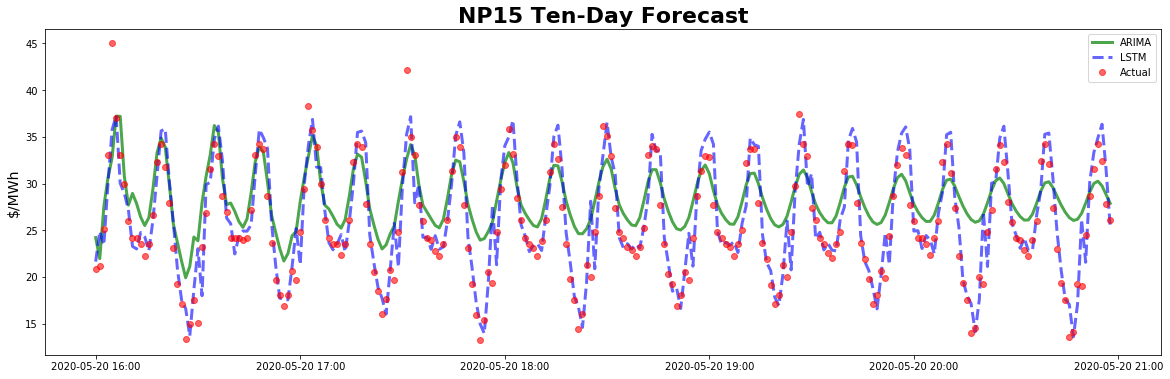

In [85]:
plot_lstm_arima_actual(np_test_rng, np_uni_arima_pred, np_lstm_pred, y1_test, 'NP15 Ten-Day Forecast')

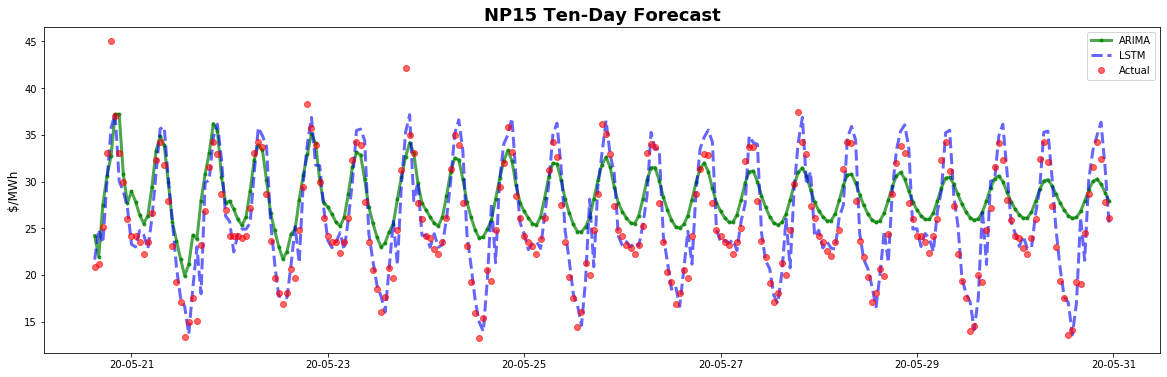

In [108]:
fig, ax = plt.subplots(figsize=(20,6))
dt_plot = caiso.index[train_test_date_delim_idx:]
ax.plot(dt_plot, np_uni_arima_pred, 'g.-', label='ARIMA', lw=3, alpha=0.7)
ax.plot(dt_plot, np_lstm_pred, 'b--', label='LSTM', lw=3, alpha=0.6)
ax.plot(dt_plot, y1_test, 'r.', label='Actual', markersize=12, alpha=0.6)
ax.set_title('NP15 Ten-Day Forecast', fontsize=18, fontweight='bold')
date_form = dates.DateFormatter("%y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.set_ylabel('$/MWh', fontsize=12)
ax.legend();

In [98]:
pandas_date = pd.to_datetime(caiso.index[train_test_date_delim_idx:])
pandas_date

DatetimeIndex(['1970-01-01 00:00:00.000011270',
               '1970-01-01 00:00:00.000011271',
               '1970-01-01 00:00:00.000011272',
               '1970-01-01 00:00:00.000011273',
               '1970-01-01 00:00:00.000011274',
               '1970-01-01 00:00:00.000011275',
               '1970-01-01 00:00:00.000011276',
               '1970-01-01 00:00:00.000011277',
               '1970-01-01 00:00:00.000011278',
               '1970-01-01 00:00:00.000011279',
               ...
               '1970-01-01 00:00:00.000011509',
               '1970-01-01 00:00:00.000011510',
               '1970-01-01 00:00:00.000011511',
               '1970-01-01 00:00:00.000011512',
               '1970-01-01 00:00:00.000011513',
               '1970-01-01 00:00:00.000011514',
               '1970-01-01 00:00:00.000011515',
               '1970-01-01 00:00:00.000011516',
               '1970-01-01 00:00:00.000011517',
               '1970-01-01 00:00:00.000011518'],
              dtype=

In [107]:
caiso.index[train_test_date_delim_idx:]

DatetimeIndex(['2020-05-20 15:00:00', '2020-05-20 16:00:00',
               '2020-05-20 17:00:00', '2020-05-20 18:00:00',
               '2020-05-20 19:00:00', '2020-05-20 20:00:00',
               '2020-05-20 21:00:00', '2020-05-20 22:00:00',
               '2020-05-20 23:00:00', '2020-05-21 00:00:00',
               ...
               '2020-05-30 14:00:00', '2020-05-30 15:00:00',
               '2020-05-30 16:00:00', '2020-05-30 17:00:00',
               '2020-05-30 18:00:00', '2020-05-30 19:00:00',
               '2020-05-30 20:00:00', '2020-05-30 21:00:00',
               '2020-05-30 22:00:00', '2020-05-30 23:00:00'],
              dtype='datetime64[ns]', name='INTERVAL_START_PT', length=249, freq=None)

### VAR - Multivariable

In [29]:
np_var_model = VAR(endog=np_multi_var_train)
model_fit = np_var_model.fit()

LinAlgError: SVD did not converge in Linear Least Squares